# SEA-AD: Scalable Exploratory Data Analysis (EDA)

**Project:** Brain GNN Transcriptomics  
**Goal:** Visualize the **FULL** SEA-AD dataset (~1.2M cells) without crashing memory.

**Strategy:**
1. Load data in **backed mode** (lazy loading from disk).
2. Subsample for intensive visualizations (UMAP/TSNE).
3. Use efficient plotting for categorical data.

In [6]:
import os
# Fix OpenMP conflict on Windows (OMP Error #15)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

### 1. Load Data (Backed Mode)
We load the .h5ad file using `backed='r'`. This keeps the data on disk and only loads metadata into memory.

In [7]:
data_path = '../data/processed/sea_ad_proc.h5ad'

if os.path.exists(data_path):
    print(f"Loading backed file: {data_path}...")
    # backed='r' is CRITICAL for 1M+ cells on consumer hardware
    adata = sc.read_h5ad(data_path, backed='r')
    print(adata)
else:
    print("File not found. Please run preprocessing first.")

Loading backed file: ../data/processed/sea_ad_proc.h5ad...
AnnData object with n_obs × n_vars = 1040014 × 36601 backed at '..\\data\\processed\\sea_ad_proc.h5ad'
    obs: 'library_prep', 'Donor ID', 'Method', 'Sex', 'Age at Death', 'Race (choice=White)', 'Race (choice=Black/ African American)', 'Race (choice=Asian)', 'Race (choice=American Indian/ Alaska Native)', 'Race (choice=Native Hawaiian or Pacific Islander)', 'Race (choice=Unknown or unreported)', 'Race (choice=Other)', 'Hispanic/Latino', 'Years of education', 'PMI', 'APOE Genotype', 'Thal', 'Braak', 'CERAD', 'ADNC', 'LATE', 'Highest Lewy Body Disease', 'Cognitive Status', 'Class', 'Subclass', 'Supertype', 'percent 6e10 positive area', 'percent AT8 positive area', 'percent NeuN positive area', 'percent GFAP positive area', 'percent aSyn positive area', 'percent pTDP43 positive area', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt'
    var: 'gene_ids', 'highly_variable', 'means', 'dispersions'
    uns: 'pca'
    obsm: 'X_pca

### 2. QC Metrics Visualization
We can visualize metadata (n_genes, total_counts) efficiently as they are already loaded in `adata.obs`.

Plotting QC Metrics distributions...


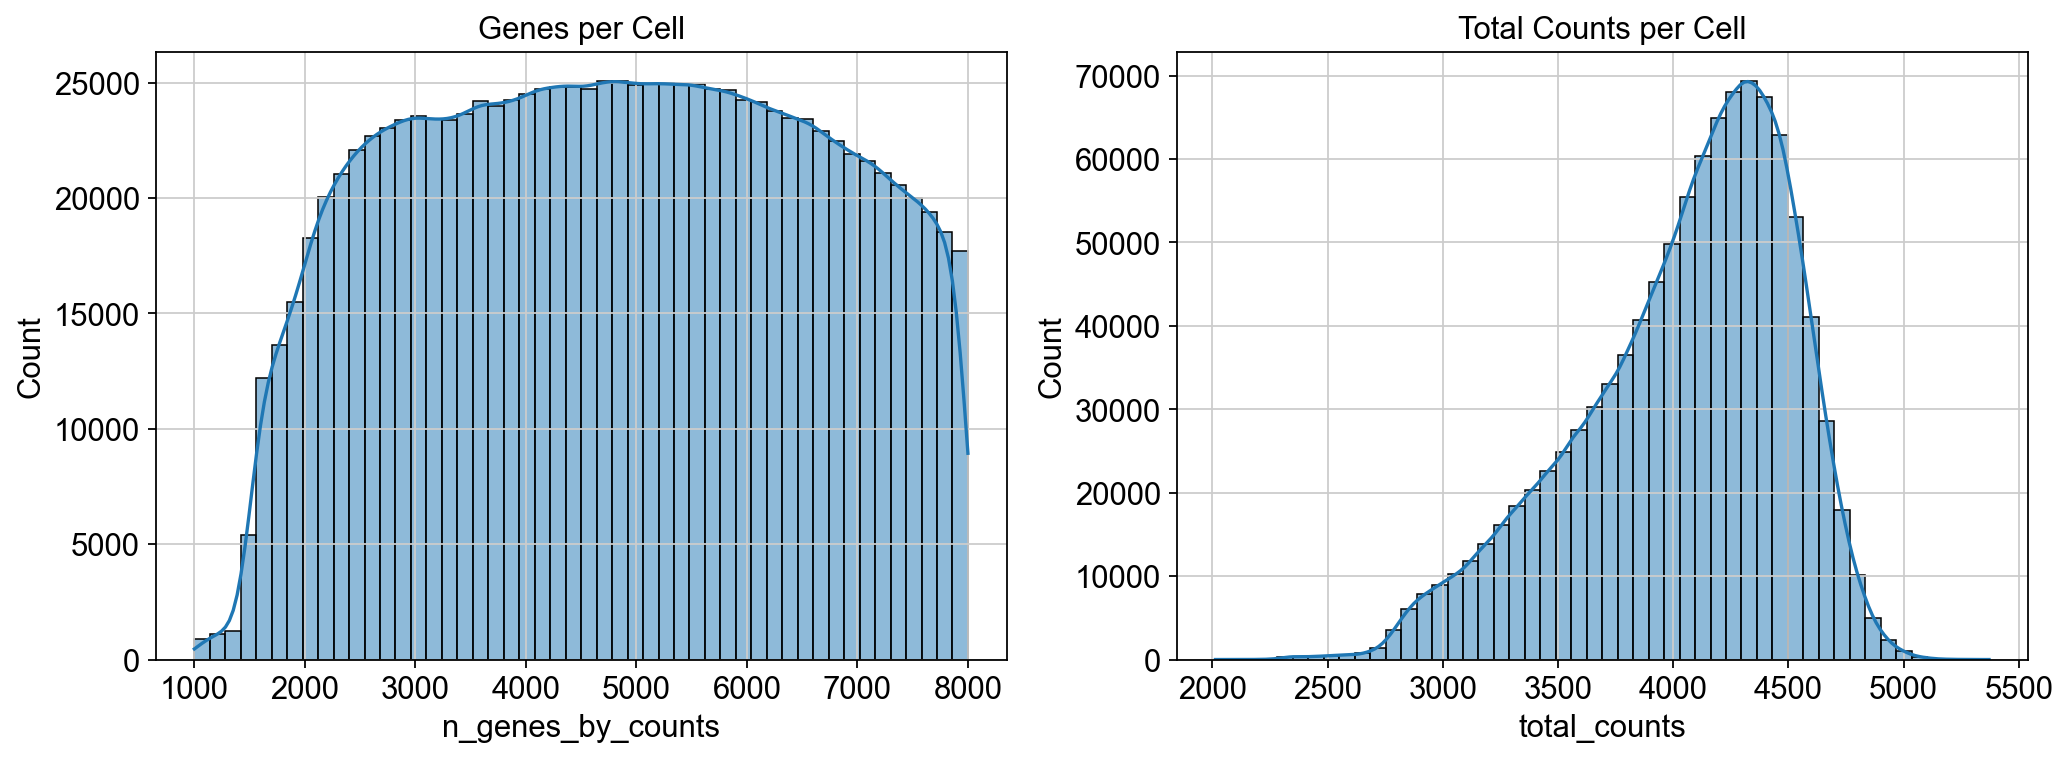

In [8]:
if 'n_genes_by_counts' in adata.obs.columns:
    print("Plotting QC Metrics distributions...")
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(adata.obs['n_genes_by_counts'], bins=50, ax=ax[0], kde=True)
    ax[0].set_title('Genes per Cell')
    
    sns.histplot(adata.obs['total_counts'], bins=50, ax=ax[1], kde=True)
    ax[1].set_title('Total Counts per Cell')
    plt.show()

### 3. Metadata Distributions
Visualizing categorical variables like 'Cognitive Status' and 'Braak Stage'.

Plotting metadata: ['Cognitive Status', 'Braak', 'APOE Genotype']


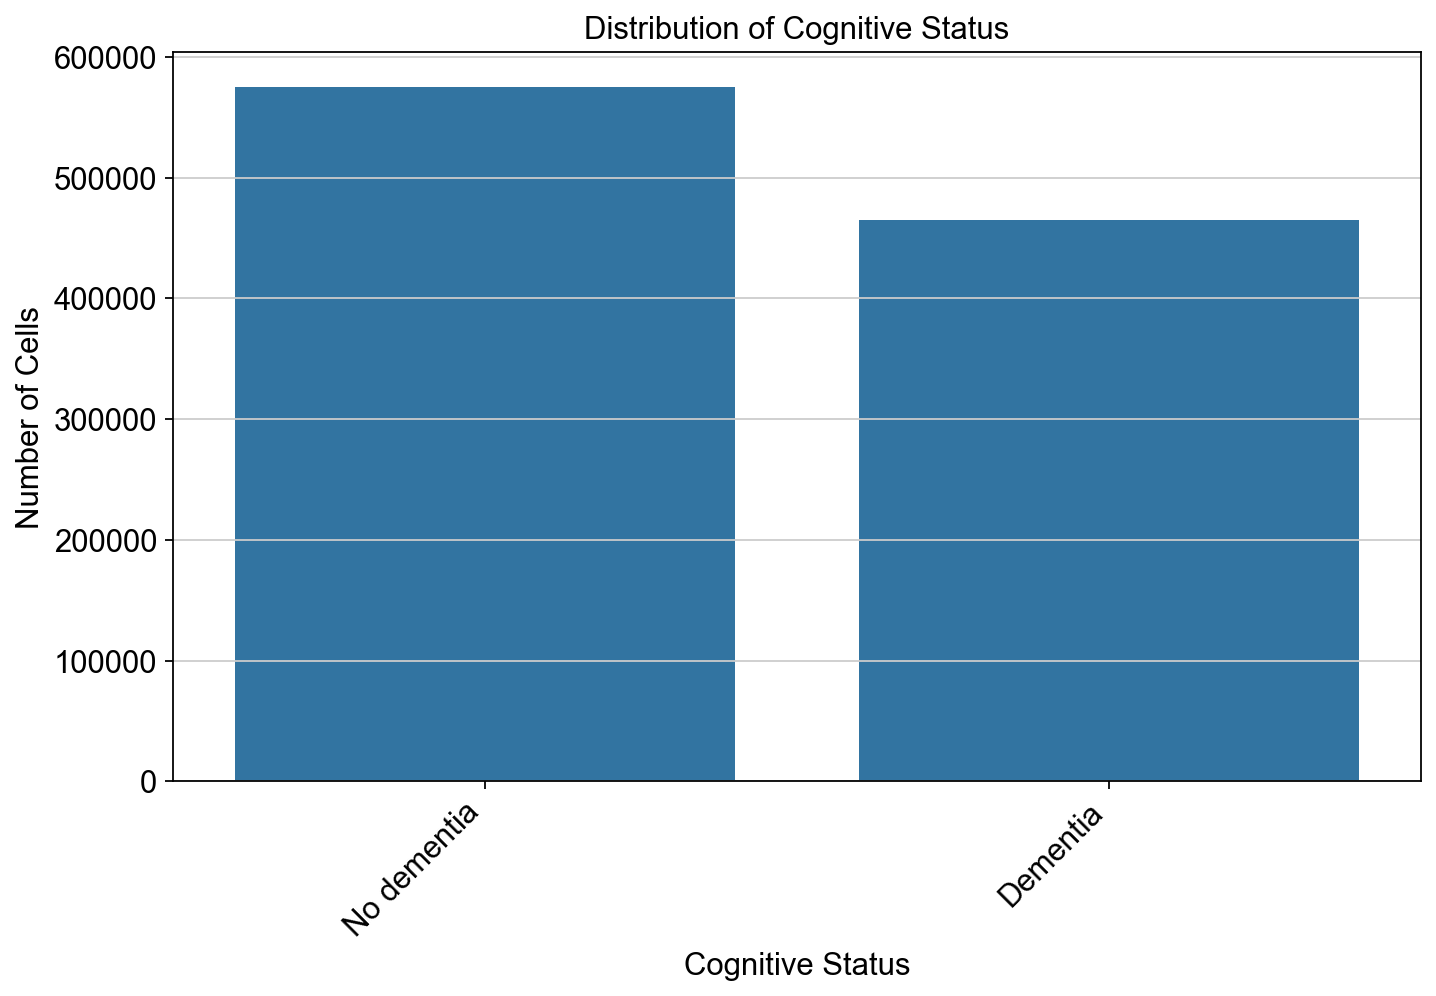

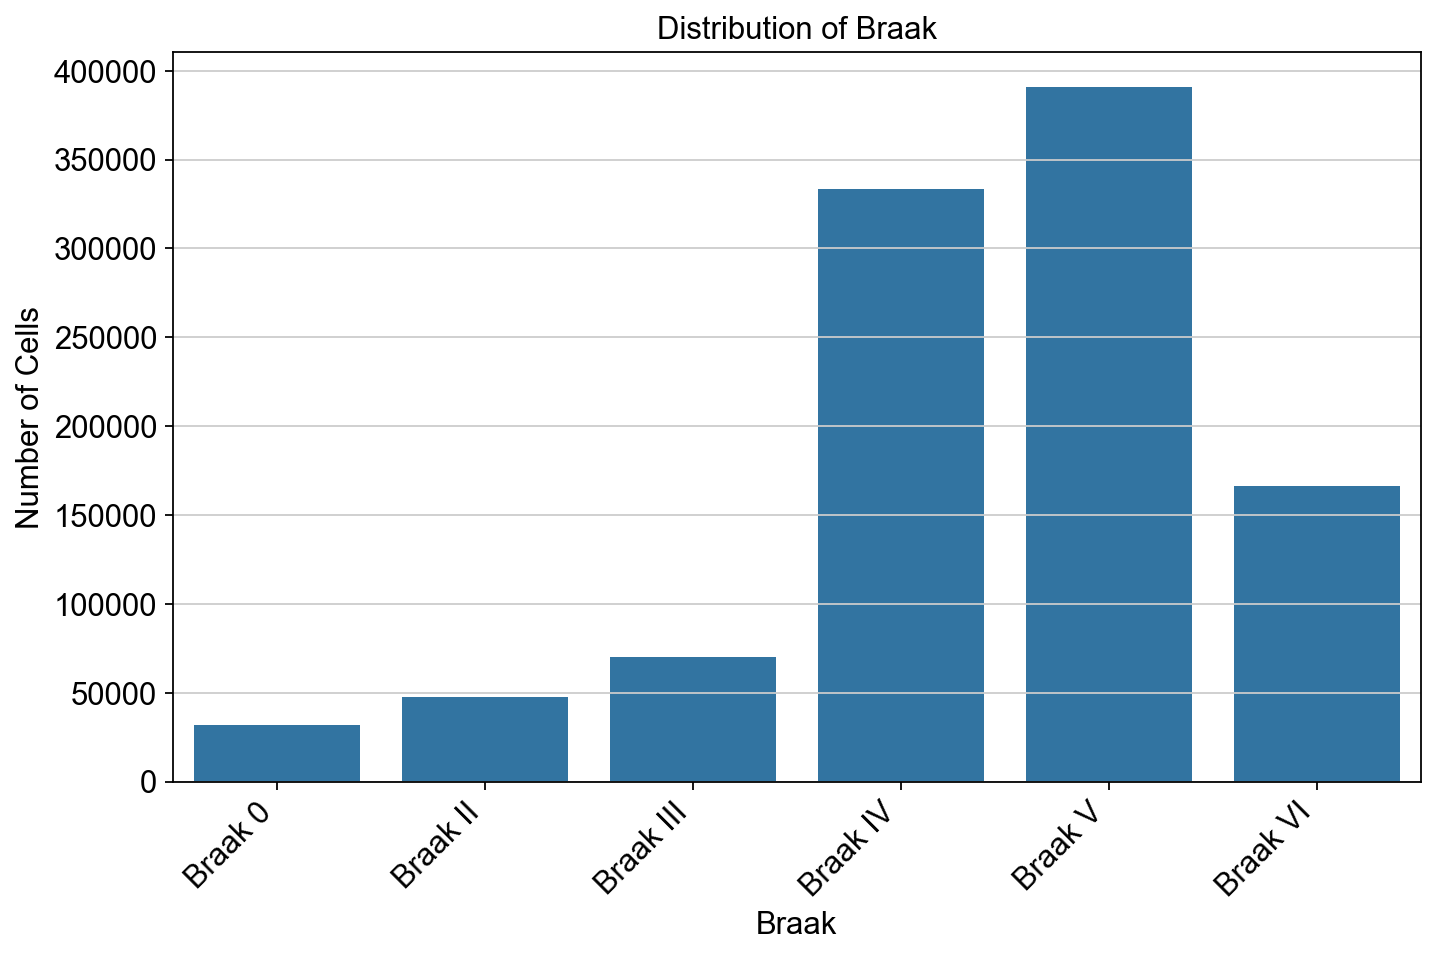

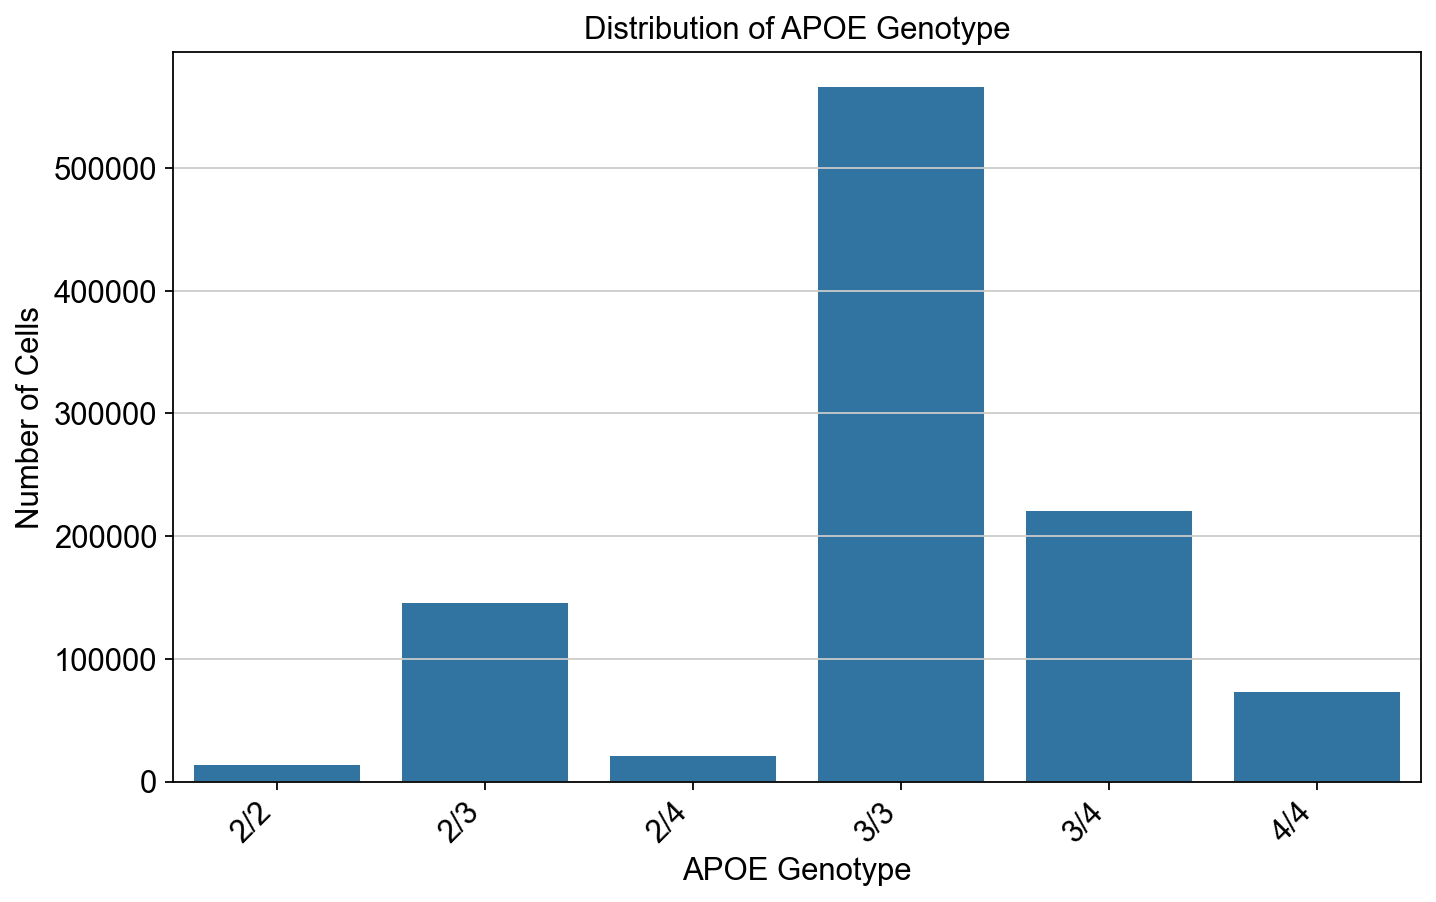

In [9]:
cols_to_plot = ['Cognitive Status', 'Braak', 'APOE Genotype', 'cell_type']
available_cols = [c for c in cols_to_plot if c in adata.obs.columns]

if available_cols:
    print(f"Plotting metadata: {available_cols}")
    for col in available_cols:
        plt.figure(figsize=(10, 6))
        # Use value_counts() which is efficient on pandas Series
        counts = adata.obs[col].value_counts()
        sns.barplot(x=counts.index, y=counts.values)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Number of Cells')
        plt.show()

### 4. Scalable UMAP Visualization
Plotting 1M points is slow. We subsample 100k random cells, compute/use UMAP, and visualize.
This gives a correct representation of the global structure without the lag.

Data has PCA: True, Data has UMAP: False
Subsampling to 100000 cells...
Computing Neighbors & UMAP on subsample (this may take a minute)...
computing neighbors
    using 'X_pca' with n_pcs = 30


c:\Users\thoma\miniconda3\envs\brain-gnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:53)
Plotting UMAP with 100000 cells...


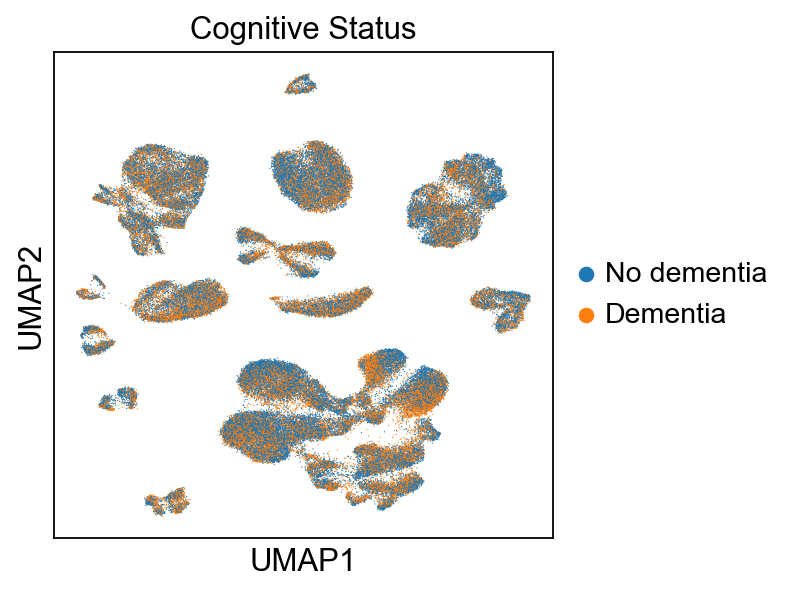

In [10]:
# Determine if we need to compute embeddings
has_umap = 'X_umap' in adata.obsm.keys()
has_pca = 'X_pca' in adata.obsm.keys()

print(f"Data has PCA: {has_pca}, Data has UMAP: {has_umap}")

# Subsample indices
n_subsample = 100000
if adata.n_obs > n_subsample:
    print(f"Subsampling to {n_subsample} cells...")
    indices = np.random.choice(adata.n_obs, n_subsample, replace=False)
    # Load only subsampled data into memory AnnData object for plotting
    adata_vis = adata[indices].to_memory()
else:
    adata_vis = adata.to_memory()

if has_umap:
    print("Using precomputed UMAP...")
    # adata_vis already has X_umap sliced correctly
    pass
elif has_pca:
    print("Computing Neighbors & UMAP on subsample (this may take a minute)...")
    # We need PCA in adata_vis.obsm['X_pca']. It should be there from slicing.
    sc.pp.neighbors(adata_vis, n_neighbors=15, n_pcs=30)
    sc.tl.umap(adata_vis)
else:
    print("Computing PCA, Neighbors & UMAP on subsample...")
    sc.pp.normalize_total(adata_vis, target_sum=1e4)
    sc.pp.log1p(adata_vis)
    sc.pp.pca(adata_vis, n_comps=50)
    sc.pp.neighbors(adata_vis)
    sc.tl.umap(adata_vis)

print(f"Plotting UMAP with {adata_vis.n_obs} cells...")
cols = ['Cognitive Status', 'cell_type', 'diagnosis']
plot_cols = [c for c in cols if c in adata_vis.obs.columns]

if plot_cols:
    sc.pl.umap(adata_vis, color=plot_cols, ncols=2)
else:
    sc.pl.umap(adata_vis)